## Imports + reproducibility

In [1]:

import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from typing import List, Tuple, Dict, Callable

In [2]:
# Reproducibility helpers
SEED = 42
def set_seed(seed: int = SEED):
    np.random.seed(seed)
    random.seed(seed)

set_seed(SEED)

In [3]:
# Matplotlib defaults
plt.rcParams.update({
    "figure.figsize": (8,5),
    "axes.grid": True,
    "font.size": 12
})

# Part A : Building Agent Based SIR

In [4]:
# Part A: Well-mixed agent-based SIR simulator
from collections import Counter

SUS, INF, REC = 0, 1, 2

In [5]:
def build_population(N: int, I0: int = 1) -> np.ndarray:
    """Return state array of length N with I0 infectious and rest susceptible."""
    states = np.full(N, SUS, dtype=np.int8)
    infectious_idx = np.random.choice(N, size=I0, replace=False)
    states[infectious_idx] = INF
    return states

In [6]:
def step_sir(states: np.ndarray, beta: float, gamma: float, C: int, dt: float) -> Tuple[np.ndarray,int]:
    """Perform one synchronous time step and return next_states and number of new infections."""
    N = len(states)
    p_trans = 1 - np.exp(-beta * dt)
    p_rec = 1 - np.exp(-gamma * dt)
    next_states = states.copy()
    new_infections = 0

    infectious_idx = np.where(states == INF)[0]
    susceptible_set = set(np.where(states == SUS)[0])

    # Each infectious agent makes up to C contacts chosen without replacement
    for i in infectious_idx:
        # sample contacts from population excluding self
        possible = np.delete(np.arange(N), i)
        # choose without replacement; if population small, allow fewer contacts
        contacts = np.random.choice(possible, size=min(C, N-1), replace=False)
        for j in contacts:
            if states[j] == SUS:
                if np.random.rand() < p_trans:
                    next_states[j] = INF
                    new_infections += 1
        # recovery
        if np.random.rand() < p_rec:
            next_states[i] = REC

    return next_states, new_infections

In [7]:
def run_sim(N: int, I0: int, beta: float, gamma: float, C: int, dt: float, T: int, seed: int = None) -> Dict:
    """Run the ABS for T steps, return dict with S/I/R time series and new infection counts."""
    if seed is not None:
        set_seed(seed)
    states = build_population(N, I0)
    S_hist, I_hist, R_hist = [], [], []
    new_infections_per_step = []
    for t in range(T):
        S_hist.append(int((states == SUS).sum()))
        I_hist.append(int((states == INF).sum()))
        R_hist.append(int((states == REC).sum()))
        states, new_inf = step_sir(states, beta, gamma, C, dt)
        new_infections_per_step.append(new_inf)
        # early stop if no infectious
        if (states == INF).sum() == 0:
            # append final counts repeated for remaining steps
            for _ in range(t+1, T):
                S_hist.append(int((states == SUS).sum()))
                I_hist.append(0)
                R_hist.append(int((states == REC).sum()))
                new_infections_per_step.append(0)
            break

    return {
        "S": np.array(S_hist),
        "I": np.array(I_hist),
        "R": np.array(R_hist),
        "new_infections": np.array(new_infections_per_step)
    }

In [8]:
# Quick sanity run
data = run_sim(N=1000, I0=5, beta=0.15, gamma=1/7, C=8, dt=1.0, T=160, seed=SEED)
print("Initial I:", data["I"][0], "Peak I:", data["I"].max())

Initial I: 5 Peak I: 639


# Plot 1 : SIR Dynamics

#### Required Plot for **Part D**

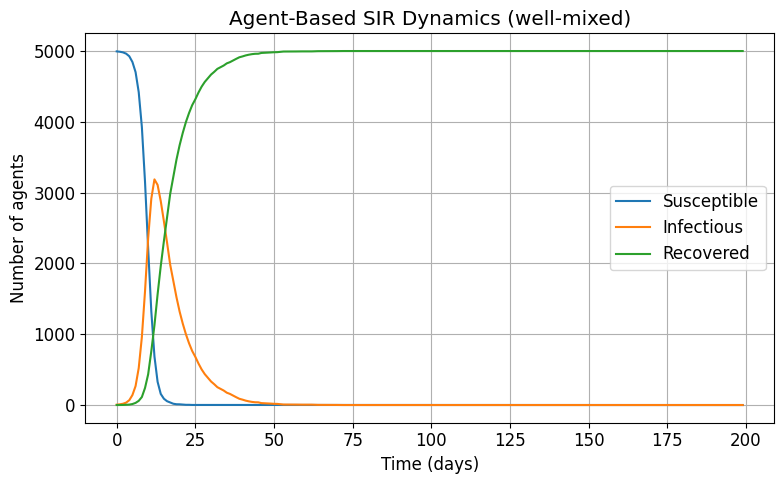

Caption: SIR dynamics from well-mixed ABS with N=5000, beta=0.15 day^-1, gamma=1/7 day^-1, C=8 contacts/step.


In [9]:
# Plot 1: SIR Dynamics
data = run_sim(N=5000, I0=5, beta=0.15, gamma=1/7, C=8, dt=1.0, T=200, seed=SEED)
t = np.arange(len(data["S"]))
plt.figure()
plt.plot(t, data["S"], label="Susceptible")
plt.plot(t, data["I"], label="Infectious")
plt.plot(t, data["R"], label="Recovered")
plt.xlabel("Time (days)")
plt.ylabel("Number of agents")
plt.title("Agent-Based SIR Dynamics (well-mixed)")
plt.legend()
plt.tight_layout()
plt.show()

print("Caption: SIR dynamics from well-mixed ABS with N=5000, beta=0.15 day^-1, gamma=1/7 day^-1, C=8 contacts/step.")

# Part B : Design and Intervention

In [10]:
# Part B: interventions
def apply_intervention_step(states: np.ndarray, beta: float, gamma: float, C: int, dt: float, u: float,
                            intervention: str = "contacts") -> Tuple[np.ndarray,int]:
    """
    Apply one SIR step with intervention intensity u in [0,1].
    intervention: "contacts" or "transmission"
    - "contacts": reduce contacts: C_eff = (1-u) * C
    - "transmission": reduce per-contact transmission: p_trans_eff = (1-u) * p_trans
    """
    if intervention == "contacts":
        C_eff = max(0, int(round((1.0 - u) * C)))
        return step_sir(states, beta, gamma, C_eff, dt)
    elif intervention == "transmission":
        # We'll simulate by adjusting beta temporarily
        beta_eff = (1.0 - u) * beta
        return step_sir(states, beta_eff, gamma, C, dt)
    else:
        raise ValueError("Unknown intervention type")

In [11]:
def cost_step(new_infections: int, u: float, lambda_epi: float = 1.0, lambda_soc: float = 0.1) -> float:
    """Per-step cost combining epidemiological and social cost."""
    return lambda_epi * new_infections + lambda_soc * (u ** 2)

In [12]:
# quick compare
set_seed(SEED)
states = build_population(1000, I0=5)
ns0, new0 = apply_intervention_step(states, beta=0.15, gamma=1/7, C=8, dt=1.0, u=0.0, intervention="contacts")
set_seed(SEED)
ns5, new5 = apply_intervention_step(states, beta=0.15, gamma=1/7, C=8, dt=1.0, u=0.5, intervention="contacts")
print("new infections u=0:", new0, "u=0.5:", new5)

new infections u=0: 3 u=0.5: 1


# Part C: RL for Intervention Optimization

In [13]:
# Part C: tabular Q-learning agent
actions = np.array([0.0, 0.25, 0.5, 0.75, 1.0])

In [14]:
def discretize_state(S_frac: float, I_frac: float, t_frac: float, n_bins: int=10, t_bins:int=10):
    """Return discrete indices for (S_frac, I_frac, t_frac)."""
    s_idx = int(np.clip(np.floor(S_frac * n_bins), 0, n_bins-1))
    i_idx = int(np.clip(np.floor(I_frac * n_bins), 0, n_bins-1))
    t_idx = int(np.clip(np.floor(t_frac * t_bins), 0, t_bins-1))
    return (s_idx, i_idx, t_idx)

In [15]:
def train_q_learning(N=1000, I0=5, beta=0.15, gamma=1/7, C=8, dt=1.0, T=150,
                     n_episodes=400, alpha=0.1, gamma_q=0.99, eps_start=0.2, eps_end=0.01,
                     n_bins=8, t_bins=10, lambda_epi=1.0, lambda_soc=0.1, intervention="contacts"):
    # Q-table dims: s_bins x i_bins x t_bins x n_actions
    Q = np.zeros((n_bins, n_bins, t_bins, len(actions)))
    history = []
    eps = eps_start

    for ep in tqdm(range(n_episodes), desc="Training Q"):
        set_seed(SEED + ep)  # reproducible per episode
        states = build_population(N, I0)
        total_reward = 0.0
        for t_step in range(T):
            S_frac = (states == SUS).sum() / N
            I_frac = (states == INF).sum() / N
            t_frac = t_step / T
            s_idx, i_idx, time_idx = discretize_state(S_frac, I_frac, t_frac, n_bins, t_bins)
            # epsilon-greedy
            if np.random.rand() < eps:
                a_idx = np.random.randint(len(actions))
            else:
                a_idx = int(np.argmax(Q[s_idx, i_idx, time_idx]))
            u = actions[a_idx]
            # step with intervention
            next_states, new_inf = apply_intervention_step(states, beta, gamma, C, dt, u, intervention)
            cost = cost_step(new_inf, u, lambda_epi=lambda_epi, lambda_soc=lambda_soc)
            reward = -cost
            total_reward += reward

            # next discrete state
            S_frac_n = (next_states == SUS).sum() / N
            I_frac_n = (next_states == INF).sum() / N
            t_frac_n = min((t_step+1)/T, 0.999)
            s_n, i_n, time_n = discretize_state(S_frac_n, I_frac_n, t_frac_n, n_bins, t_bins)

            # Q update
            best_next = Q[s_n, i_n, time_n].max()
            td_target = reward + gamma_q * best_next
            Q[s_idx, i_idx, time_idx, a_idx] += alpha * (td_target - Q[s_idx, i_idx, time_idx, a_idx])

            states = next_states
            # early termination if no infectious left
            if (states == INF).sum() == 0:
                break

        # decay epsilon linearly
        eps = max(eps_end, eps - (eps_start - eps_end) / n_episodes)
        history.append(total_reward)
    # extract greedy policy
    best_policy_idx = np.argmax(Q, axis=-1)
    return {
        "Q": Q,
        "policy_idx": best_policy_idx,
        "history": np.array(history)
    }

In [ ]:
# Quick start training (faster run for demo)
train_res = train_q_learning(N=1000, I0=5, beta=0.15, gamma=1/7, C=8, dt=1.0, T=120, n_episodes=150, alpha=0.1, gamma_q=0.99, eps_start=0.2, eps_end=0.01, n_bins=6, t_bins=8, lambda_epi=1.0, lambda_soc=0.1, intervention="contacts")

Training Q:   0%|          | 0/150 [00:00<?, ?it/s]

## Plot 3: RL Training Curve

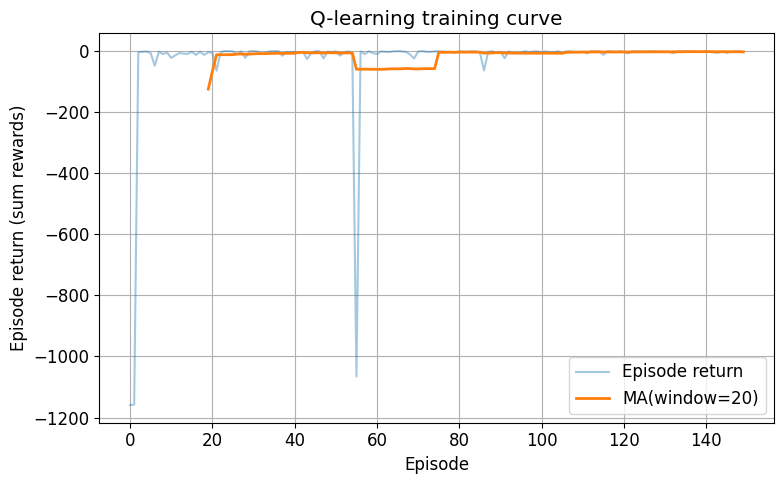

In [17]:
# Plot 3: RL training curve
hist = train_res["history"]
episodes = np.arange(len(hist))
window = 20
ma = np.convolve(hist, np.ones(window)/window, mode='valid')

plt.figure()
plt.plot(episodes, hist, alpha=0.4, label="Episode return")
plt.plot(np.arange(window-1, len(hist)), ma, label=f"MA(window={window})", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Episode return (sum rewards)")
plt.title("Q-learning training curve")
plt.legend()
plt.tight_layout()
plt.show()

# Part D: Experiments & Plot 2 (Beta vs empirical Ro)

In [18]:
# Part D: empirical R0 estimation (index-case method)
def estimate_R0_empirical(beta: float, gamma: float, C: int, dt: float, N: int, repetitions: int = 100):
    sec_counts = []
    for rep in range(repetitions):
        set_seed(SEED + rep)
        # create population and track index
        states = build_population(N, I0=1)
        # locate index case (the one infectious initially)
        index_idx = np.where(states == INF)[0][0]
        index_recovered = False
        secondary = 0
        # track who infected by whom - minimal approach: track only infections while index is INF
        infected_by_index = set()
        while True:
            # If index not infectious anymore, stop counting (we follow the assignment)
            if states[index_idx] != INF:
                break
            # simulate deterministic contacts for this step from index
            # sample contacts for index only
            possible = np.delete(np.arange(N), index_idx)
            contacts = np.random.choice(possible, size=min(C, N-1), replace=False)
            p_trans = 1 - np.exp(-beta * dt)
            for j in contacts:
                if states[j] == SUS:
                    if np.random.rand() < p_trans:
                        states[j] = INF
                        infected_by_index.add(j)
            # now process recoveries for all infectious (including index)
            # For simplicity, sample recoveries
            inf_idx = np.where(states == INF)[0]
            for i in inf_idx:
                if np.random.rand() < (1 - np.exp(-gamma*dt)):
                    states[i] = REC
            # continue until index not INF
        sec_counts.append(len(infected_by_index))
    return np.mean(sec_counts), np.std(sec_counts) / np.sqrt(repetitions)

Estimating R0:   0%|          | 0/11 [00:00<?, ?it/s]

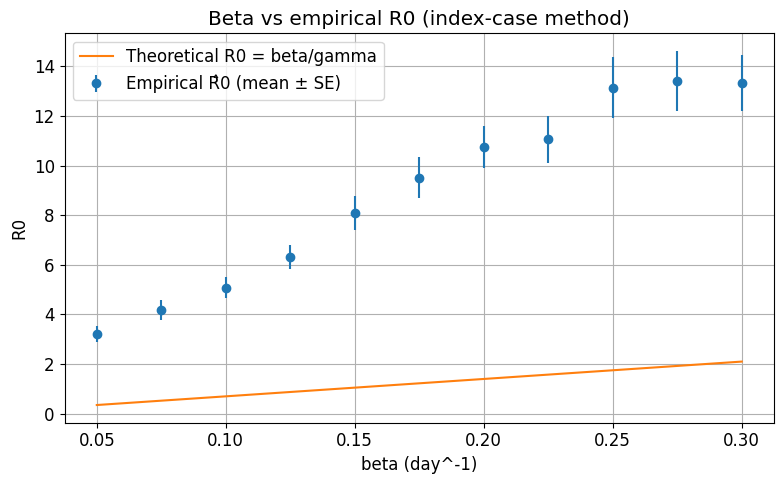

In [19]:
# Run over grid
betas = np.arange(0.05, 0.305, 0.025)
R_hat_means = []
R_hat_se = []
for b in tqdm(betas, desc="Estimating R0"):
    mean_r, se_r = estimate_R0_empirical(beta=b, gamma=1/7, C=8, dt=1.0, N=1000, repetitions=120)
    R_hat_means.append(mean_r)
    R_hat_se.append(se_r)
R_hat_means = np.array(R_hat_means)
R_hat_se = np.array(R_hat_se)

# Plot scatter + theoretical R0 = beta/gamma
gamma_val = 1/7
plt.figure()
plt.errorbar(betas, R_hat_means, yerr=R_hat_se, fmt='o', label="Empirical R̂0 (mean ± SE)")
plt.plot(betas, betas / gamma_val, label="Theoretical R0 = beta/gamma")
plt.xlabel("beta (day^-1)")
plt.ylabel("R0")
plt.title("Beta vs empirical R0 (index-case method)")
plt.legend()
plt.tight_layout()
plt.show()

### Baselines and Comparisons

In [20]:
# Evaluate policies
def eval_policy(policy_fn: Callable, N, I0, beta, gamma, C, dt, T, lambda_epi, lambda_soc):
    set_seed(SEED + 999)
    states = build_population(N, I0)
    total_cost = 0.0
    for t in range(T):
        S_frac = (states == SUS).sum() / N
        I_frac = (states == INF).sum() / N
        t_frac = t / T
        u = policy_fn(S_frac, I_frac, t_frac)
        states, new_inf = apply_intervention_step(states, beta, gamma, C, dt, u, intervention="contacts")
        total_cost += cost_step(new_inf, u, lambda_epi=lambda_epi, lambda_soc=lambda_soc)
        if (states == INF).sum() == 0:
            break
    final_outbreak = (states == REC).sum()
    return total_cost, final_outbreak

In [21]:
# define policies
no_intervention = lambda s,i,t: 0.0
const_half = lambda s,i,t: 0.5
# learned policy using train_res["policy_idx"]
policy_idx = train_res["policy_idx"]

In [22]:
def greedy_policy(s_frac,i_frac,t_frac):
    s,i,tidx = discretize_state(s_frac,i_frac,t_frac, n_bins=6, t_bins=8)
    a_idx = int(policy_idx[s,i,tidx])
    return float(actions[a_idx])

In [23]:
# Evaluate
N_eval=1000
beta_eval=0.15
gamma_eval=1/7
C_eval=8
T_eval=150
lam_epi, lam_soc = 1.0, 0.1

results = {}
results["no_intervention"] = eval_policy(no_intervention, N_eval, 5, beta_eval, gamma_eval, C_eval, 1.0, T_eval, lam_epi, lam_soc)
results["const_0.5"] = eval_policy(const_half, N_eval, 5, beta_eval, gamma_eval, C_eval, 1.0, T_eval, lam_epi, lam_soc)
results["learned"] = eval_policy(greedy_policy, N_eval, 5, beta_eval, gamma_eval, C_eval, 1.0, T_eval, lam_epi, lam_soc)

# print summary
for k,v in results.items():
    print(f"{k}: total_cost={v[0]:.2f}, final_recovered={v[1]}")

no_intervention: total_cost=1179.00, final_recovered=1000
const_0.5: total_cost=1079.83, final_recovered=991
learned: total_cost=2.50, final_recovered=5
